In [62]:
# Imports
import pandas as pd
import numpy as np
import requests # For the currency exchange rates
from forex_python.converter import CurrencyRates
from plotnine import ggplot, geom_histogram, aes, theme, guides, guide_legend
import seaborn as sns
from plotnine.themes.themeable import legend_position
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
#import statsmodels.formula.api as smf
#import statsmodels.api as sm

# Data input, cleaning, transformation, and validation

In [2]:
# First, we import the data
file = "salary_responses.csv"
data = pd.read_csv(file)
c = CurrencyRates()

In [3]:
# Data cleaning, validation
# We delete the columns that are not helpful for our purposes, such as timestamp, additional context for title, and for income
data = data.drop( data.columns[[0,4,9]],axis=1)
# We now change the names of the columns to make manipulation easier
data.columns = ["Age", "Industry", "Job Title", "Annual Salary", "Bonus", 
                "Currency", "Alternate Currency", "Country", "US State", "US City", 
                "Work experience", "Work experience in field", "Education", "Gender", "Race"]

In [4]:
# Now we drop NA values from some columns, such as Annual Salary, Education, Race, and Gender, 
# as these columns are useful for predictions and model creation, and we cannot use them if they are incomplete
data.dropna(subset=["Annual Salary", "Education", "Race", "Gender"], inplace=True)

In [5]:
# As we can see here: 
print(type(data["Annual Salary"][0]))
# The type for Annual Salary is string, which is not ideal when we want to add these numbers
# So we need to change the type from string to numeric
data["Annual Salary"] = data["Annual Salary"].apply(lambda f: float(f.split()[0].replace(',', '')))
data["Annual Salary"] = data["Annual Salary"].astype(float)

# Now we need to change the NaN values from Bonus to 0
data["Bonus"] = data["Bonus"].fillna(0)
data["Total"] = data["Annual Salary"] + data["Bonus"]

# Now that the total has been calculated, we do not need the columns Bonus and Annual Salary
data.drop(["Annual Salary", "Bonus"], axis = 1, inplace=True)

<class 'str'>


In [6]:
# The other problem is the value "Other". These observations use a currency in the "Alternate Currency" column. But this column
# allowed for user input, which, as we know, is not ideal. 
# As we can see, the values are too varied, written not in currency code, and explanations instead of the currency
# First, we set everything to uppercase, to avoid issues with some written in lower and others in uppercase
data["Alternate Currency"] = data["Alternate Currency"].str.upper()
data["Alternate Currency"] = data["Alternate Currency"].str.strip()
data["Alternate Currency"] = data["Alternate Currency"].fillna("NONE")
data.loc[data["Alternate Currency"].str.contains("ARGENT"), "Alternate Currency"] = "ARS"
data.loc[data["Alternate Currency"].str.contains("MEXIC"), "Alternate Currency"] = "MXN"
data.loc[data["Alternate Currency"].str.contains("IND"), "Alternate Currency"] = "INR"
data.loc[data["Alternate Currency"].str.contains("ZWOTY"), "Alternate Currency"] = "PLN"
data.loc[data["Alternate Currency"].str.contains("POLISH"), "Alternate Currency"] = "PLN"
data.loc[data["Alternate Currency"].str.contains("AMERI"), "Alternate Currency"] = "USD"
data.loc[data["Alternate Currency"].str.contains("CANA"), "Alternate Currency"] = "CAD"
data.loc[data["Alternate Currency"].str.contains("CHIN"), "Alternate Currency"] = "CNY"
data.loc[data["Alternate Currency"].str.contains("NIS"), "Alternate Currency"] = "ILS"
data.loc[data["Alternate Currency"].str.contains("TAIW"), "Alternate Currency"] = "TWD"
data.loc[data["Alternate Currency"].str.contains("PHIL"), "Alternate Currency"] = "PHP"
data.loc[data["Alternate Currency"].str.contains("KOREAN"), "Alternate Currency"] = "KRW"
data.loc[data["Alternate Currency"].str.contains("ISRAEL"), "Alternate Currency"] = "ILS"
data.loc[data["Alternate Currency"].str.contains("AUSTRA"), "Alternate Currency"] = "AUD"
data.loc[data["Alternate Currency"].str.contains("THAI"), "Alternate Currency"] = "THB"
data.loc[data["Alternate Currency"].str.contains("CROAT"), "Alternate Currency"] = "HRK"
data.loc[data["Alternate Currency"].str.contains("SINGAP"), "Alternate Currency"] = "SGD"
data.replace({"Alternate Currency": {"BR$":"BRL","BRL (R$)" : "BRL","CZECH CROWNS" : "CZK", "NORWEGIAN KRONER (NOK)" : "NOK", 
                                "US DOLLAR" : "USD", "EURO" : "EUR", "NTD" : "TWD"}}, inplace=True)
# After replacing these values, we can delete everything that is over 3 characters in length, or less than 3, 
# as these are either not valid currencies, or not clear enough to use
data.drop(data[data["Alternate Currency"] == "N/A"].index, inplace=True)
data = data[data["Alternate Currency"].str.len() < 4]
data = data[data["Alternate Currency"].str.len() > 2]
alt_cur = data["Alternate Currency"].unique()

In [7]:
# Cleaning job title, which is a user-input field
data["Job Title"] = data["Job Title"].str.upper()
data["Job Title"] = data["Job Title"].str.strip()
data.loc[data["Job Title"].str.contains("EdataEC"), "Job Title"] = "EdataECUTIVE"
data.loc[data["Job Title"].str.contains("CONSULTANT"), "Job Title"] = "CONSULTANT"
data.loc[data["Job Title"].str.contains("TEACH"), "Job Title"] = "TEACHER"
data.loc[data["Job Title"].str.contains("MANAGER")|
      data["Job Title"].str.contains("ADMIN"), "Job Title"] = "MANAGER"
data.loc[data["Job Title"].str.contains("ACCOUNTANT"), "Job Title"] = "ACCOUNTANT"
data.loc[data["Job Title"].str.contains("SPECIALIST"), "Job Title"] = "SPECIALIST"
data.loc[data["Job Title"].str.contains("ANALYST"), "Job Title"] = "ANALYST"
data.loc[data["Job Title"].str.contains("ASSOCIATE"), "Job Title"] = "ASSOCIATE"
data.loc[data["Job Title"].str.contains("LEGAL"), "Job Title"] = "LEGAL"
data.loc[data["Job Title"].str.contains("ASSISTANT"), "Job Title"] = "ASSISTANT"
data.loc[data["Job Title"].str.contains("ARTIST"), "Job Title"] = "ARTIST"
data.loc[data["Job Title"].str.contains("ADVISOR"), "Job Title"] = "ADVISOR"
data.loc[data["Job Title"].str.contains("RESEARCH")|
      data["Job Title"].str.contains("R&D")|
      data["Job Title"].str.contains("SCIENTIST"), "Job Title"] = "RESEARCH"
data.loc[data["Job Title"].str.contains("LEAD"), "Job Title"] = "LEAD"
data.loc[data["Job Title"].str.contains("SOFTWARE")|
      data["Job Title"].str.contains("DEVELOPER"), "Job Title"] = "SWE"
data.loc[data["Job Title"].str.contains("ENGI"), "Job Title"] = "ENGINEER"
data.loc[data["Job Title"].str.contains("SENIOR"), "Job Title"] = "SENIOR"
temp = pd.DataFrame(data["Job Title"].value_counts(), columns=['count'])
jobs_to_other = temp[temp["count"]==1]["count"].index.values.tolist()
jobs_to_other = '|'.join(jobs_to_other)
data.loc[data["Job Title"].str.contains(jobs_to_other), "Job Title"] = "OTHER"
data["Job Title"].value_counts()

Job Title
OTHER         63
MANAGER       27
SWE           20
ASSISTANT     12
ENGINEER      11
CONSULTANT     7
SPECIALIST     6
ANALYST        4
ASSOCIATE      3
ADVISOR        2
SENIOR         2
LEGAL          2
Name: count, dtype: int64

In [8]:
# Now we can perform the exchange between alternate currencies and USD
key = ""
url = "https://v6.exchangerate-api.com/v6/" + key + "/pair/"#+ "/latest/USD"
print(alt_cur)
ex_rat = {}
for ac in alt_cur:
    #break
    s = url + ac + "/USD"
    r = requests.get(s)#.json()["conversion_rate"]
    #print(r)
    rjson = r.json()
    #print(rjson)
    c = rjson["conversion_rate"]
    #print(c)
    ex_rat[ac] = c

['INR' 'ARS' 'MYR' 'CHF' 'KWD' 'NOK' 'USD' 'BRL' 'SEK' 'CAD' 'DKK' 'EUR'
 'COP' 'TTD' 'MXN' 'CZK' 'GBP' 'ZAR' 'PHP' 'PLN' 'TRY' 'CNY' 'ILS' 'AUD'
 'TWD' 'NZD' 'SGD' 'KRW' 'THB' 'IDR' 'LKR' 'SAR' 'HRK' 'NGN']


In [9]:
for i in data.index: 
    data["Total"][i] = data["Total"][i] * ex_rat[data["Alternate Currency"][i]]
data["Total"]
data.loc[data["Alternate Currency"] == "USD"]

/tmp/ipykernel_243/3296464058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_243/3296464058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_243/3296464058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_243/3296464058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,Age,Industry,Job Title,Currency,Alternate Currency,Country,US State,US City,Work experience,Work experience in field,Education,Gender,Race,Total
2473,25-34,Nonprofits,MANAGER,Other,USD,USA,Maine,Portland,8 - 10 years,8 - 10 years,College degree,Woman,White,48568.0
7402,45-54,Education (Higher Education),ASSISTANT,Other,USD,U.S.A.,Washington,Seattle,31 - 40 years,21 - 30 years,College degree,Woman,White,76500.0
9410,35-44,Retail,ASSOCIATE,Other,USD,USA,Massachusetts,Franklin,11 - 20 years,5-7 years,"Professional degree (MD, JD, etc.)",Woman,White,29600.0
10150,45-54,Property or Construction,OTHER,Other,USD,USA,Illinois,Rockford,31 - 40 years,21 - 30 years,Some college,Woman,White,51500.0
11434,25-34,Law,SPECIALIST,Other,USD,USA,District of Columbia,"Washington, DC",5-7 years,5-7 years,"Professional degree (MD, JD, etc.)",Woman,Black or African American,91000.0
11788,45-54,Health care,OTHER,Other,USD,US,Oregon,Portland,11 - 20 years,5-7 years,College degree,Woman,White,120000.0
12481,45-54,"Accounting, Banking & Finance",OTHER,USD,USD,United States,Texas,Waco,11 - 20 years,11 - 20 years,College degree,Woman,White,97000.0
17588,25-34,Computing or Tech,SWE,USD,USD,USA,Washington,Seattle,8 - 10 years,5-7 years,High School,Man,Asian or Asian American,370000.0
19416,25-34,Computing or Tech,OTHER,Other,USD,US,Illinois,Chicago,5-7 years,2 - 4 years,PhD,Woman,Asian or Asian American,135000.0
21036,25-34,Insurance,SPECIALIST,Other,USD,USA,Texas,Houston,5-7 years,5-7 years,College degree,Woman,White,74000.0


In [10]:
# Finally, as every observation is now in the same currency, we can get rid of the columns Currency and Alternate Currency
data.drop(columns=["Currency", "Alternate Currency"], inplace=True)
data.head()

,Age,Industry,Job Title,Country,US State,US City,Work experience,Work experience in field,Education,Gender,Race,Total
434,25-34,Computing or Tech,ANALYST,India,NaN,Pune,2 - 4 years,2 - 4 years,Master's degree,Woman,Asian or Asian American,10761.600
603,45-54,Health care,MANAGER,Argentina,NaN,City of Buenos Aires,11 - 20 years,11 - 20 years,College degree,Woman,"Hispanic, Latino, or Spanish origin",4782.010
1311,25-34,Government and Public Administration,ASSOCIATE,Malaysia,NaN,Kuala Lumpur,5-7 years,2 - 4 years,College degree,Woman,Another option not listed here or prefer not t...,22206.240
1840,35-44,Intergovernmental organization,CONSULTANT,Switzerland,NaN,Geneva,11 - 20 years,5-7 years,Master's degree,Woman,Black or African American,68982.000
1915,35-44,Education (Primary/Secondary),OTHER,Kuwait,NaN,Hawalli,11 - 20 years,1 year or less,Master's degree,Woman,White,44160.852


In [11]:
# We can also create income brackets, which would turn our only numerical label into a categorical label. 
# For the brackets, the tax brackets for income in the United States were used
#data["Total"] = pd.cut(data["Total"], [0,11000, 44725, 95375, 182100, 231250, 578125 ,float("inf")])
#data.Total.value_counts()

In [12]:
# Country cleaning
data["Country"] = data["Country"].str.upper()
data["Country"] = data["Country"].str.strip()
data.loc[data["Country"].str.contains("ARGENTINA"), "Country"] = "ARGENTINA"
data.loc[data["Country"].str.contains("CHINA"), "Country"] = "CHINA"
data.loc[data["Country"].str.contains("U.S.A") | 
      data["Country"].str.contains("USA") |
      data["Country"].str.contains("UNITED STATES")|
      data["Country"].str.match("US"), "Country"] = "USA"
data.loc[data["Country"].str.contains("AUSTRALIA"), "Country"] = "AUSTRALIA"
data.loc[data["Country"].str.contains("CZECH"), "Country"] = "CZECH REPUBLIC"
data.loc[data["Country"].str.contains("XICO"), "Country"] = "MEXICO"
data.loc[data["Country"].str.contains("BRAZIL") |
      data["Country"].str.contains("BRASIL"), "Country"] = "BRAZIL"

In [13]:
data.Country.value_counts()

Country
USA                    13
DENMARK                12
NORWAY                 12
INDIA                  11
SINGAPORE              11
AUSTRALIA               9
MALAYSIA                8
BRAZIL                  8
POLAND                  8
CZECH REPUBLIC          6
ARGENTINA               6
PHILIPPINES             6
ISRAEL                  6
CHINA                   4
NEW ZEALAND             4
MEXICO                  4
SOUTH KOREA             4
CANADA                  4
THAILAND                3
INDONESIA               2
COLOMBIA                2
TAIWAN                  2
SRI LANKA               1
SAUDI ARABIA            1
IRELAND                 1
CROATIA                 1
SOUTH AFRICA            1
TURKEY                  1
UK                      1
SCOTLAND                1
TRINIDAD AND TOBAGO     1
HUNGARY                 1
SWEDEN                  1
KUWAIT                  1
SWITZERLAND             1
NIGERIA                 1
Name: count, dtype: int64

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159 entries, 434 to 27902
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       159 non-null    object 
 1   Industry                  158 non-null    object 
 2   Job Title                 159 non-null    object 
 3   Country                   159 non-null    object 
 4   US State                  13 non-null     object 
 5   US City                   159 non-null    object 
 6   Work experience           159 non-null    object 
 7   Work experience in field  159 non-null    object 
 8   Education                 159 non-null    object 
 9   Gender                    159 non-null    object 
 10  Race                      159 non-null    object 
 11  Total                     159 non-null    float64
dtypes: float64(1), object(11)
memory usage: 20.2+ KB


As we can see here, most fields are categorical, with only total being numerical. 
This is because the categories that could be numerical or boolean, such as Age and Gender, include a window for different values, and for Gender, there is the possibility to include non-binary genders. 

# Visualization

/mnt/c/Users/rino2/OneDrive/Documentos/Maestria/Fourth Quarter - Summer 2023/Data Science Tools 1/DataScienceTools1/dst1_env/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 25'. Pick better value with 'binwidth'.


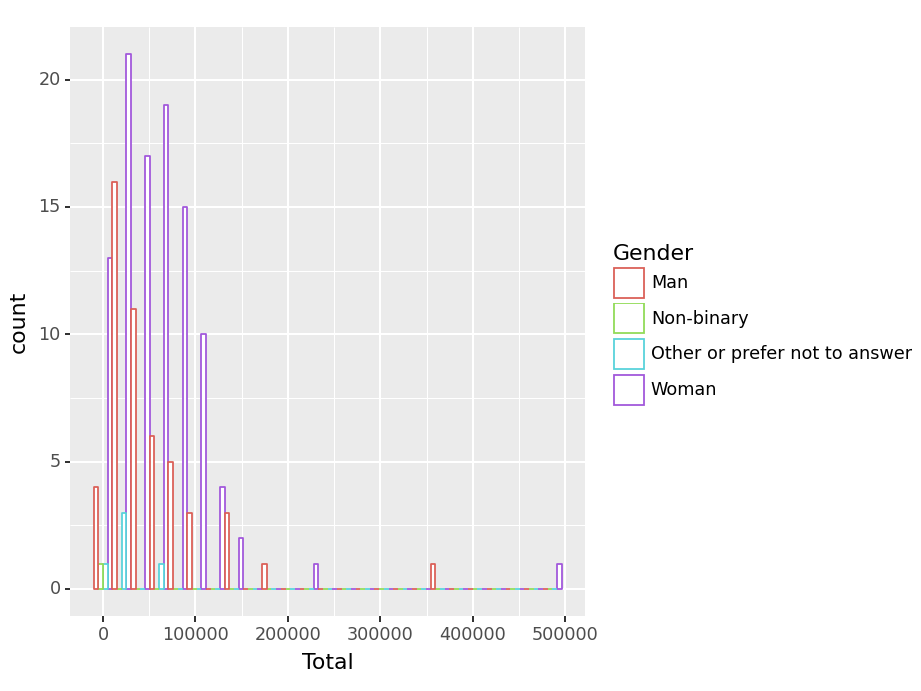

<Figure Size: (460 x 345)>

In [15]:
p = (
ggplot(data, aes(x="Total", color="Gender"))+
    geom_histogram(fill="white", position="dodge")
)
p

In [16]:
data.Gender.value_counts()

Gender
Woman                            103
Man                               50
Other or prefer not to answer      5
Non-binary                         1
Name: count, dtype: int64

It can be observed that not only most of the responses in the survey are from women, and most of the original >120000 responses have been deleted. 
It cannot be observed a direct relationship between Gender and Total

/mnt/c/Users/rino2/OneDrive/Documentos/Maestria/Fourth Quarter - Summer 2023/Data Science Tools 1/DataScienceTools1/dst1_env/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 25'. Pick better value with 'binwidth'.


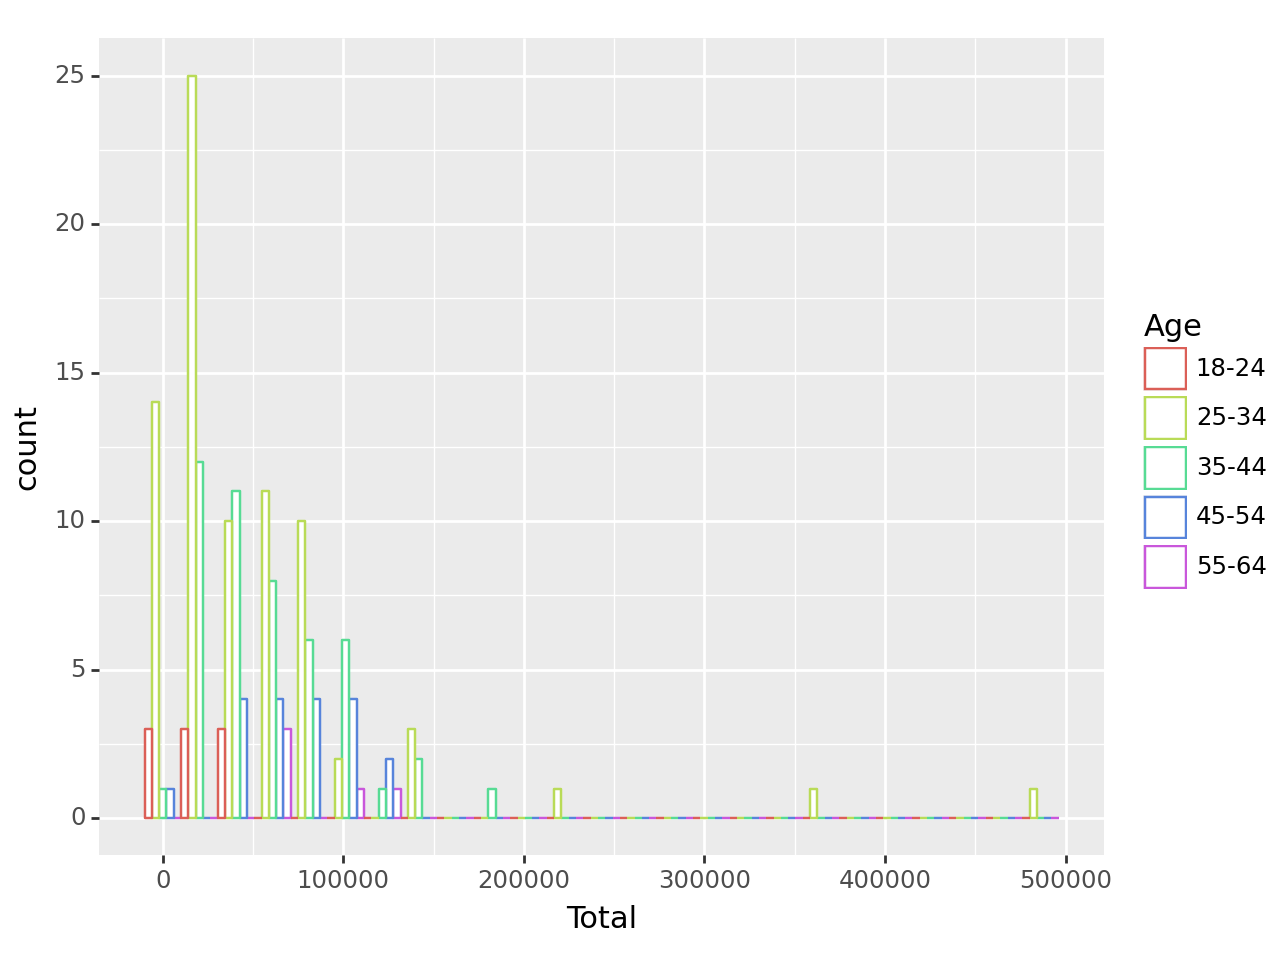

<Figure Size: (640 x 480)>

In [17]:
p = (
ggplot(data, aes(x="Total", color="Age"))+
    geom_histogram(fill="white", position="dodge")
)
p

It can be observed that most of the participants are in the range of 25-34, and most of them are in the Total range between 0 and 50k. 
Unfortunately, as previously seen, most of the participants are in the range of 25-34, which creates a bias in any model that can be produced with this data (after cleaning). 

/mnt/c/Users/rino2/OneDrive/Documentos/Maestria/Fourth Quarter - Summer 2023/Data Science Tools 1/DataScienceTools1/dst1_env/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 4'. Pick better value with 'binwidth'.


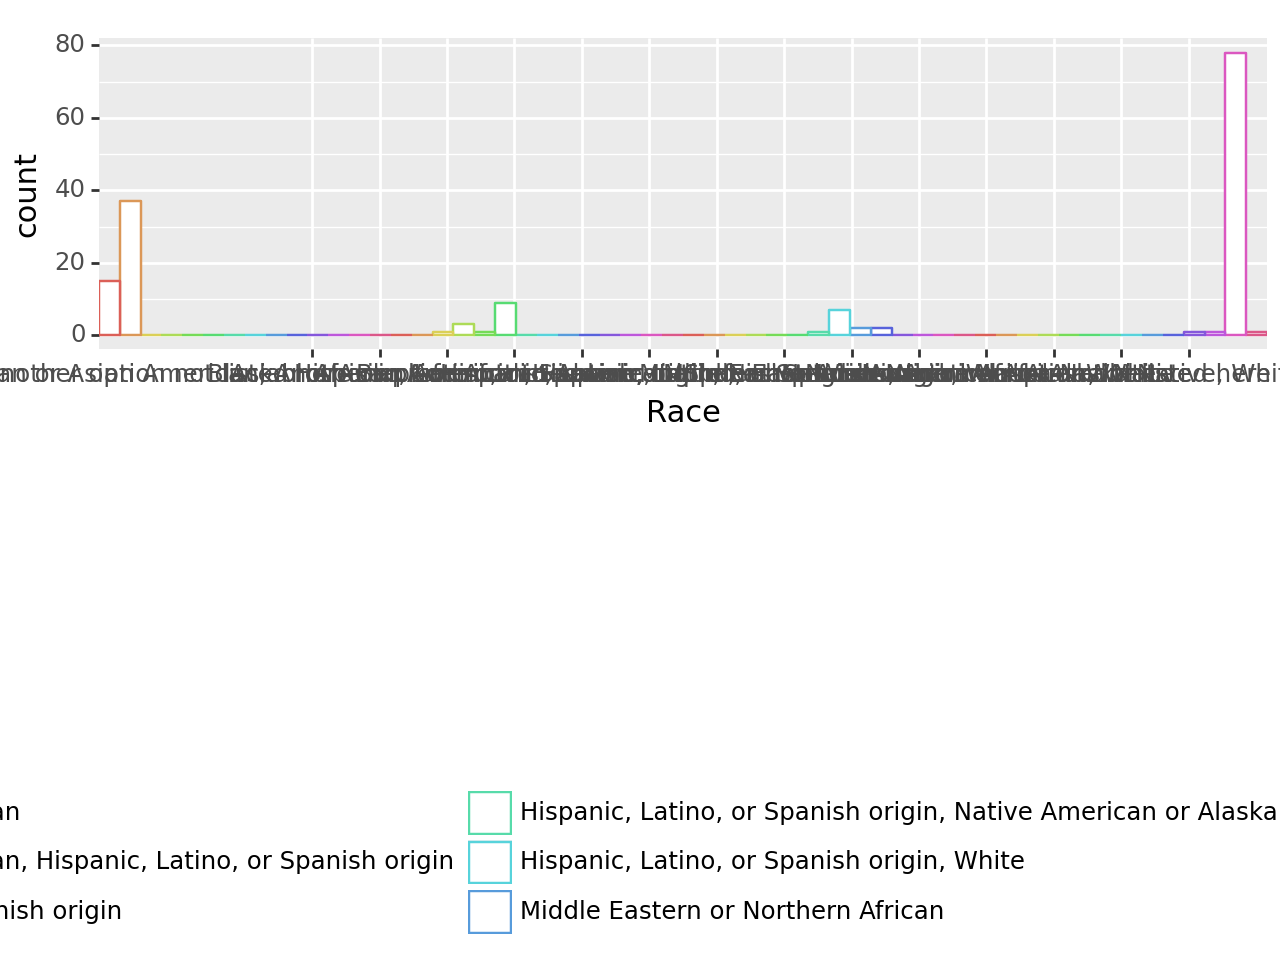

<Figure Size: (640 x 480)>

In [18]:
p = (
ggplot(data, aes(x="Race", color="Race"))+
    geom_histogram(fill="white", position="dodge") +
    theme(
        legend_direction='horizontal',
        legend_position='bottom',
        legend_box_spacing=0.25,
  ) +
 guides(fill=guide_legend(nrow=5, byrow=True))
)
p

In [19]:
data.Race.value_counts()

Race
White                                                                              78
Asian or Asian American                                                            37
Another option not listed here or prefer not to answer                             15
Hispanic, Latino, or Spanish origin                                                 9
Hispanic, Latino, or Spanish origin, White                                          7
Black or African American                                                           3
Middle Eastern or Northern African, White                                           2
Middle Eastern or Northern African                                                  2
White, Another option not listed here or prefer not to answer                       1
Black or African American, Hispanic, Latino, or Spanish origin                      1
Hispanic, Latino, or Spanish origin, Native American or Alaska Native               1
Asian or Asian American, Another option not liste

As we can see in both the plot and the previous method, most of the participants are Caucasian, followed by Asian. This may also present an issue with the creation of a model, as there is a strong bias for the data to take heavily into consideration both Caucasian and Asian races. 

In [20]:
data.Country.value_counts()

Country
USA                    13
DENMARK                12
NORWAY                 12
INDIA                  11
SINGAPORE              11
AUSTRALIA               9
MALAYSIA                8
BRAZIL                  8
POLAND                  8
CZECH REPUBLIC          6
ARGENTINA               6
PHILIPPINES             6
ISRAEL                  6
CHINA                   4
NEW ZEALAND             4
MEXICO                  4
SOUTH KOREA             4
CANADA                  4
THAILAND                3
INDONESIA               2
COLOMBIA                2
TAIWAN                  2
SRI LANKA               1
SAUDI ARABIA            1
IRELAND                 1
CROATIA                 1
SOUTH AFRICA            1
TURKEY                  1
UK                      1
SCOTLAND                1
TRINIDAD AND TOBAGO     1
HUNGARY                 1
SWEDEN                  1
KUWAIT                  1
SWITZERLAND             1
NIGERIA                 1
Name: count, dtype: int64

Unfortunately, in the Country column we can observe that most of the responses are from the USA. However, the responses are slightly more distributed in the first 10 countries in the list. 

/mnt/c/Users/rino2/OneDrive/Documentos/Maestria/Fourth Quarter - Summer 2023/Data Science Tools 1/DataScienceTools1/dst1_env/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 25'. Pick better value with 'binwidth'.


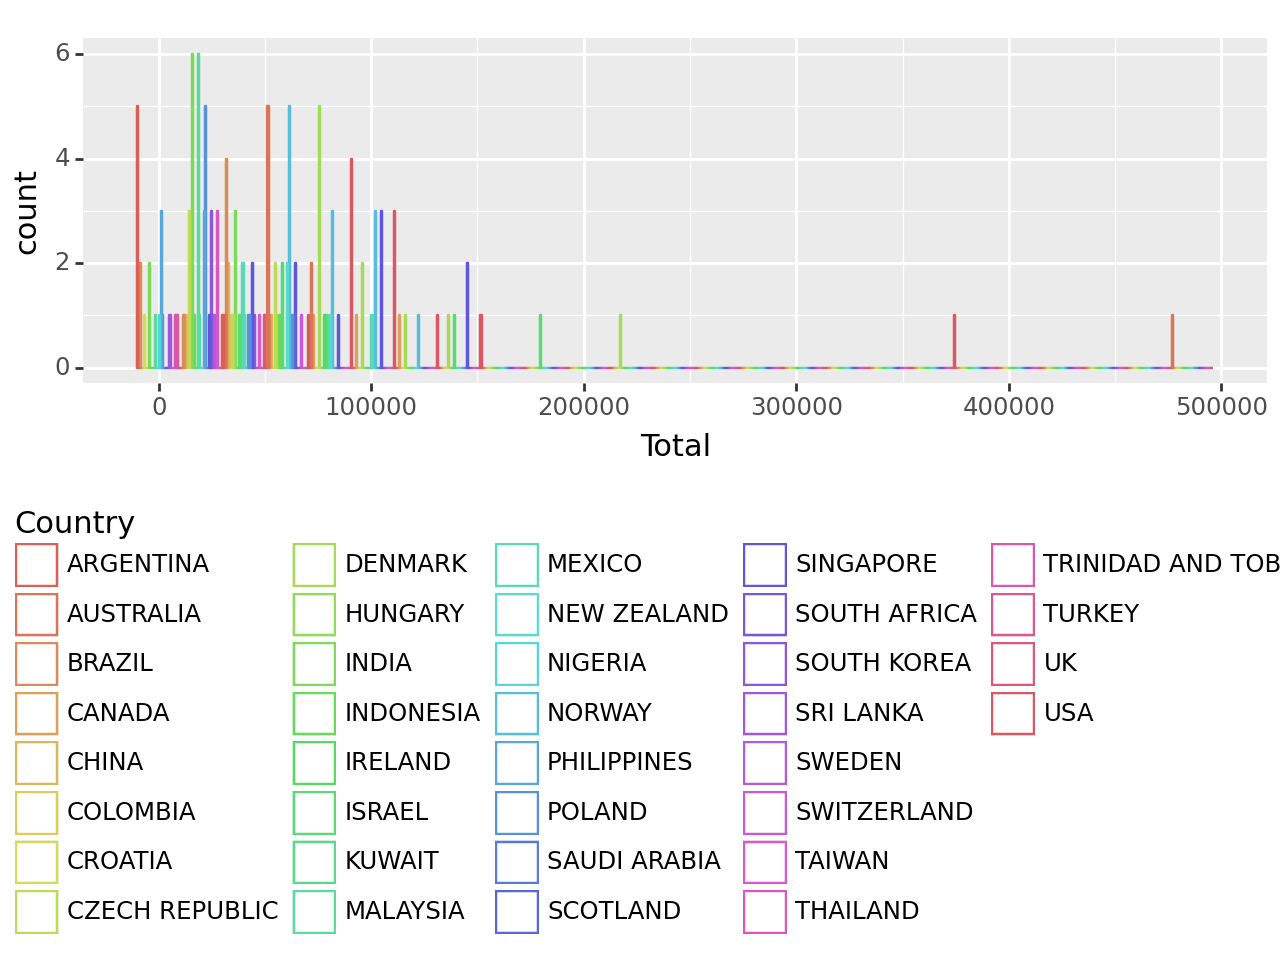

<Figure Size: (640 x 480)>

In [21]:
p = (
ggplot(data, aes(x="Total", color="Country"))+
    geom_histogram(fill="white", position="dodge") +
    theme(
        legend_direction='horizontal',
        legend_position='bottom'
  ) 
)
p

In [22]:
data.Total.value_counts()

Total
10761.60     1
74000.00     1
2862.60      1
12280.28     1
135000.00    1
            ..
91000.00     1
65646.90     1
101439.00    1
70675.20     1
30385.20     1
Name: count, Length: 159, dtype: int64

# Modelling

Now that the data has been cleaned, the next step is to use this clean data to create predictive models in order to be able to associate different variables, such as country of origin, race, gender, age, etc. 
In order to be able to use most algorithms, the data needs to be either numerical, or one-hot encoded.
Several models will be tried: 
* Nearest Neighbors Classification
* Random forest

In [23]:
# Fist, some columns can be dropped, such as state and city. as these values are just too varied, they really wont help much
data = data.drop(["US State", "US City"], axis=1)
data.head()

,Age,Industry,Job Title,Country,Work experience,Work experience in field,Education,Gender,Race,Total
434,25-34,Computing or Tech,ANALYST,INDIA,2 - 4 years,2 - 4 years,Master's degree,Woman,Asian or Asian American,10761.600
603,45-54,Health care,MANAGER,ARGENTINA,11 - 20 years,11 - 20 years,College degree,Woman,"Hispanic, Latino, or Spanish origin",4782.010
1311,25-34,Government and Public Administration,ASSOCIATE,MALAYSIA,5-7 years,2 - 4 years,College degree,Woman,Another option not listed here or prefer not t...,22206.240
1840,35-44,Intergovernmental organization,CONSULTANT,SWITZERLAND,11 - 20 years,5-7 years,Master's degree,Woman,Black or African American,68982.000
1915,35-44,Education (Primary/Secondary),OTHER,KUWAIT,11 - 20 years,1 year or less,Master's degree,Woman,White,44160.852


## KNN

In [36]:
# As the data is categorical, it needs to be set to one-hot encoded
data_prep = data.copy()
data_prep = data_prep.drop("Total", axis=1)
x_encoded = pd.get_dummies(data_prep, prefix=["Age", "Industry", "Job Title",
                                "Country", "Work experience", "Work experience in field", "Education", "Gender", "Race"], drop_first=True)
x_encoded.head()
y = data.copy()
y["Total"] = pd.cut(y["Total"], [0,11000, 44725, 95375, 182100, 231250, 578125 ,float("inf")])
y = y["Total"]
y_encoded = pd.get_dummies(y, prefix=["Total"], drop_first=True)
y_encoded.head()

,"['Total']_(11000.0, 44725.0]","['Total']_(44725.0, 95375.0]","['Total']_(95375.0, 182100.0]","['Total']_(182100.0, 231250.0]","['Total']_(231250.0, 578125.0]","['Total']_(578125.0, inf]"
434,False,False,False,False,False,False
603,False,False,False,False,False,False
1311,True,False,False,False,False,False
1840,False,True,False,False,False,False
1915,True,False,False,False,False,False


In [37]:
# Nearest Neighbors Classification
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_encoded, y_encoded)

KNeighborsClassifier(n_neighbors=3)

In [38]:
# We perform a prediction with this data
print(data_prep.iloc[1])
print(data.iloc[1]["Total"])

Age                                                       45-54
Industry                                            Health care
Job Title                                               MANAGER
Country                                               ARGENTINA
Work experience                                   11 - 20 years
Work experience in field                          11 - 20 years
Education                                        College degree
Gender                                                    Woman
Race                        Hispanic, Latino, or Spanish origin
Name: 603, dtype: object
4782.01


In [29]:
#! pip uninstall scikit-learn -y
#! pip install scikit-learn==1.2.2
#! pip show scikit-learn

In [39]:
pred = np.array(x_encoded.iloc[1])
knn.predict(pred.reshape(1,-1))

/mnt/c/Users/rino2/OneDrive/Documentos/Maestria/Fourth Quarter - Summer 2023/Data Science Tools 1/DataScienceTools1/dst1_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


array([[False, False,  True, False, False, False]])

As it can be seen in the prediction, this model does not work correctly for wages that fall outside the brackets of taxes for the US. 
The annual salary for a healthcare manager in Argentina is 4782 USD. This is far below the expected value, which is within 95375 and 182100 USD. 
The prediction model fails to account for these differences.
Now another test can be done with an observation of wages in the US, or with wages similar to the US

In [43]:
print(data_prep.iloc[3])
print(data.iloc[3]["Total"])
print(y_encoded.iloc[3])

Age                                                  35-44
Industry                    Intergovernmental organization
Job Title                                       CONSULTANT
Country                                        SWITZERLAND
Work experience                              11 - 20 years
Work experience in field                         5-7 years
Education                                  Master's degree
Gender                                               Woman
Race                             Black or African American
Name: 1840, dtype: object
68982.0
['Total']_(11000.0, 44725.0]      False
['Total']_(44725.0, 95375.0]       True
['Total']_(95375.0, 182100.0]     False
['Total']_(182100.0, 231250.0]    False
['Total']_(231250.0, 578125.0]    False
['Total']_(578125.0, inf]         False
Name: 1840, dtype: bool


In [42]:
pred = np.array(x_encoded.iloc[3])
knn.predict(pred.reshape(1,-1))

/mnt/c/Users/rino2/OneDrive/Documentos/Maestria/Fourth Quarter - Summer 2023/Data Science Tools 1/DataScienceTools1/dst1_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


array([[False,  True, False, False, False, False]])

As it can be seen, the prediction was a success for a person in a country with wages similar to the US
Afterwards, a comparison can be made with every observation available in the dataset

In [57]:
pred_res = knn.predict(x_encoded)
actual_vals = y_encoded.values
comparison = pred_res == actual_vals
#print(comparison)
results = {True: 0, False: 0}
for c in comparison:
    if False in c:
        results[False]+=1
    else:
        results[True]+=1
print(results)


{True: 96, False: 63}


In [61]:
success_rate = results[True] / (results[True] + results[False])
print(success_rate)

0.6037735849056604


As we can see, this simple model has a 60% succcess rate

## Random Fores

In [63]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_encoded, y_encoded)

RandomForestClassifier(max_depth=2, random_state=0)

In [65]:
# We perform a prediction with this data
print(data_prep.iloc[1])
print(data.iloc[1]["Total"])

Age                                                       45-54
Industry                                            Health care
Job Title                                               MANAGER
Country                                               ARGENTINA
Work experience                                   11 - 20 years
Work experience in field                          11 - 20 years
Education                                        College degree
Gender                                                    Woman
Race                        Hispanic, Latino, or Spanish origin
Name: 603, dtype: object
4782.01


In [66]:
pred = np.array(x_encoded.iloc[1])
clf.predict(pred.reshape(1,-1))

/mnt/c/Users/rino2/OneDrive/Documentos/Maestria/Fourth Quarter - Summer 2023/Data Science Tools 1/DataScienceTools1/dst1_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[False, False, False, False, False, False]])

In [67]:
# We perform a prediction with this data
print(data_prep.iloc[3])
print(data.iloc[3]["Total"])

Age                                                  35-44
Industry                    Intergovernmental organization
Job Title                                       CONSULTANT
Country                                        SWITZERLAND
Work experience                              11 - 20 years
Work experience in field                         5-7 years
Education                                  Master's degree
Gender                                               Woman
Race                             Black or African American
Name: 1840, dtype: object
68982.0


In [68]:
pred = np.array(x_encoded.iloc[3])
clf.predict(pred.reshape(1,-1))

/mnt/c/Users/rino2/OneDrive/Documentos/Maestria/Fourth Quarter - Summer 2023/Data Science Tools 1/DataScienceTools1/dst1_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[False, False, False, False, False, False]])

In [69]:
clf.predict(x_encoded)

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False,  True, False, Fa